In [17]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from itertools import product
import random
import math
import pickle
from tqdm.notebook import tqdm_notebook
import sys
import scipy
from scipy.optimize import curve_fit
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
sys.path.append('../')
import fn

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing results locally

In [19]:
import addition_data
import addition_eval
from LSTM import LSTM
from RNN import RNN
import time

In [71]:
with open('../pickles/carry_tables/all_tables_d1_b2-6.pickle', 'rb') as f:
    all_tables = pickle.load(f)

In [92]:
b = 3
tables = all_tables[b]

In [93]:
table = tables[((0,)*b,)*b]

In [94]:
training_dataloader, testing_dataloader = addition_data.prepare(b, 6, table, batch_size=64, split_type='OOD', split_depth=3, sample=True)

In [ ]:
model = RNN(b, 1)
loss, training_acc, testing_acc = addition_eval.eval(
    model, training_dataloader, testing_dataloader, lr=0.0001,
    num_passes=1000000, log_interval=10000, print_loss_and_acc=True
)

t = 0
loss = 1.068795, training_acc = 0.000, testing_acc = 0.000

t = 10000
loss = 0.710435, training_acc = 0.000, testing_acc = 0.000

t = 20000
loss = 0.658694, training_acc = 0.074, testing_acc = 0.000

t = 30000
loss = 0.552300, training_acc = 0.222, testing_acc = 0.074



In [ ]:
plt.plot(training_acc)

In [ ]:
lrs = np.linspace(0.01, 0.1, 5)
n_trials = 5

# t0 = time.time()
test_acc_vs_lr = {}
for lr in lrs:
    print('lr =', lr, '\n')
    avg_testing_acc = np.zeros(25)
    for _ in range(n_trials):
        model = RNN(b, 1)
        loss, training_acc, testing_acc = addition_eval.eval(
            model, training_dataloader, testing_dataloader, lr=lr,
            num_passes=250, log_interval=10, print_loss_and_acc=True
        )
        avg_testing_acc += 1/n_trials * np.array(testing_acc)
    test_acc_vs_lr[lr] = avg_testing_acc
# print(time.time() - t0)

In [ ]:
for lr, testing_acc in test_acc_vs_lr.items():
    plt.plot(testing_acc, alpha=0.5, label=lr)
plt.legend()

For b=3, lr=0.02,0.04 achieved fastest results (w/ batch_size=16)

For b=4, lr=0.04 achieved fastest results (w/ batch_size=64)


Seems like batch_size=16 is sweet spot for base 3, and batch_size=64 is sweet spot for base 4, 5

In [37]:
with open(f'../pickles/learning_metrics/learning_metrics3_RNN_5trials.pickle', 'rb') as f:
    learning_metrics = pickle.load(f)

Text(0, 0.5, 'Test Accuracy')

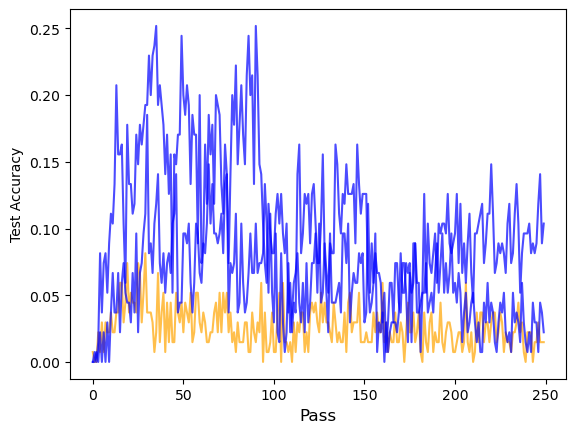

In [38]:
for dc in learning_metrics.keys():
    test_acc = learning_metrics[dc]['testing_acc']
    est_dim = est_dim_box_vs_depth[3][dc][3]
    if len(np.unique(all_tables[3][dc])) == 2:
        unit, = plt.plot(test_acc, color='blue', alpha=0.7, label='Single Value', zorder=3)
    elif est_dim > 1.25 and est_dim < 1.5:
        special_non_unit, = plt.plot(test_acc, color='orange', alpha=0.7, label='Low Dim. Multiple Value', zorder=2)
    else:
        non_unit, = plt.plot(test_acc, color='silver', alpha=0.7, label='Other Multiple Value', zorder=1)
plt.xlabel('Pass', fontsize=12)
plt.ylabel('Test Accuracy')

## Plot Learning Speeds

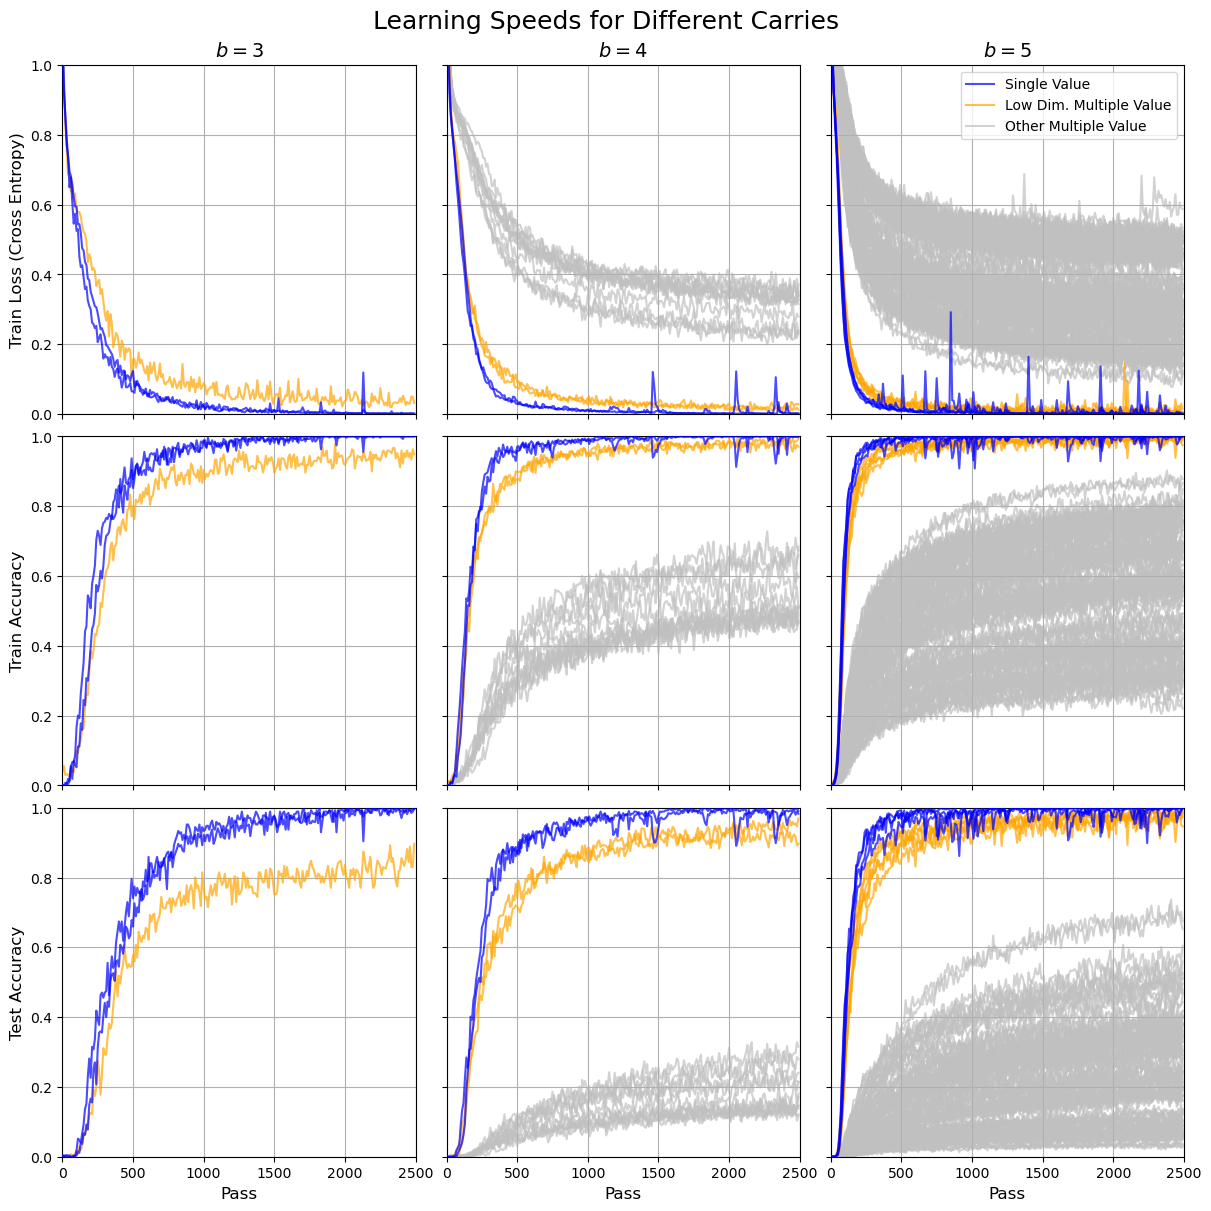

In [29]:
# create subplots, title figure
fig, axes = plt.subplots(3, 3, figsize=(12, 12), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Learning Speeds for Different Carries', fontsize=18)

for i in range(3):
    for j in range(3):

        # get b, learning speeds
        b = i + 3
        with open(f'../pickles/learning_metrics/learning_metrics{b}_10trials.pickle', 'rb') as f:
            learning_metrics = pickle.load(f)

        # get ax, set basic formatting
        ax = axes[j, i]
        ax.grid(True)
        ax.set_xlim(0, 250)
        ax.set_ylim(0)
        ax.set_xticks(np.linspace(0, 250, 6), np.linspace(0, 2500, 6).astype('int'))

        # loss plot
        if j == 0:
            ax.set_title(f'$b = {b}$', fontsize=14)
            for dc in learning_metrics.keys():
                loss = learning_metrics[dc]['loss']
                est_dim = est_dim_box_vs_depth[b][dc][3]
                if len(np.unique(all_tables[b][dc])) == 2:
                    unit, = ax.plot(loss, color='blue', alpha=0.7, label='Single Value', zorder=3)
                elif est_dim > 1.25 and est_dim < 1.5:
                    special_non_unit, = ax.plot(loss, color='orange', alpha=0.7, label='Low Dim. Multiple Value', zorder=2)
                else:
                    non_unit, = ax.plot(loss, color='silver', alpha=0.7, label='Other Multiple Value', zorder=1)
            if i == 0:
                ax.set_ylabel('Train Loss (Cross Entropy)', fontsize=12)
            elif i == 2:
                ax.legend(handles=[unit, special_non_unit, non_unit])
    
        # training accuracy plot
        if j == 1:
            for dc in learning_metrics.keys():
                train_acc = learning_metrics[dc]['training_acc']
                est_dim = est_dim_box_vs_depth[b][dc][3]
                if len(np.unique(all_tables[b][dc])) == 2:
                    unit, = ax.plot(train_acc, color='blue', alpha=0.7, label='Single Value', zorder=3)
                elif est_dim > 1.25 and est_dim < 1.5:
                    special_non_unit, = ax.plot(train_acc, color='orange', alpha=0.7, label='Low Dim. Multiple Value', zorder=2)
                else:
                    non_unit, = ax.plot(train_acc, color='silver', alpha=0.7, label='Other Multiple Value', zorder=1)
            if i == 0:
                ax.set_ylabel('Train Accuracy', fontsize=12)
    
        # testing accuracy plot
        if j == 2:
            for dc in learning_metrics.keys():
                test_acc = learning_metrics[dc]['testing_acc']
                est_dim = est_dim_box_vs_depth[b][dc][3]
                if len(np.unique(all_tables[b][dc])) == 2:
                    unit, = ax.plot(test_acc, color='blue', alpha=0.7, label='Single Value', zorder=3)
                elif est_dim > 1.25 and est_dim < 1.5:
                    special_non_unit, = ax.plot(test_acc, color='orange', alpha=0.7, label='Low Dim. Multiple Value', zorder=2)
                else:
                    non_unit, = ax.plot(test_acc, color='silver', alpha=0.7, label='Other Multiple Value', zorder=1)
            ax.set_xlabel('Pass', fontsize=12)
            if i == 0:
                ax.set_ylabel('Test Accuracy', fontsize=12)
    # plt.savefig('../figures/learning_speeds.png', dpi=300)

## Adding and Shuffling Digit Ordering

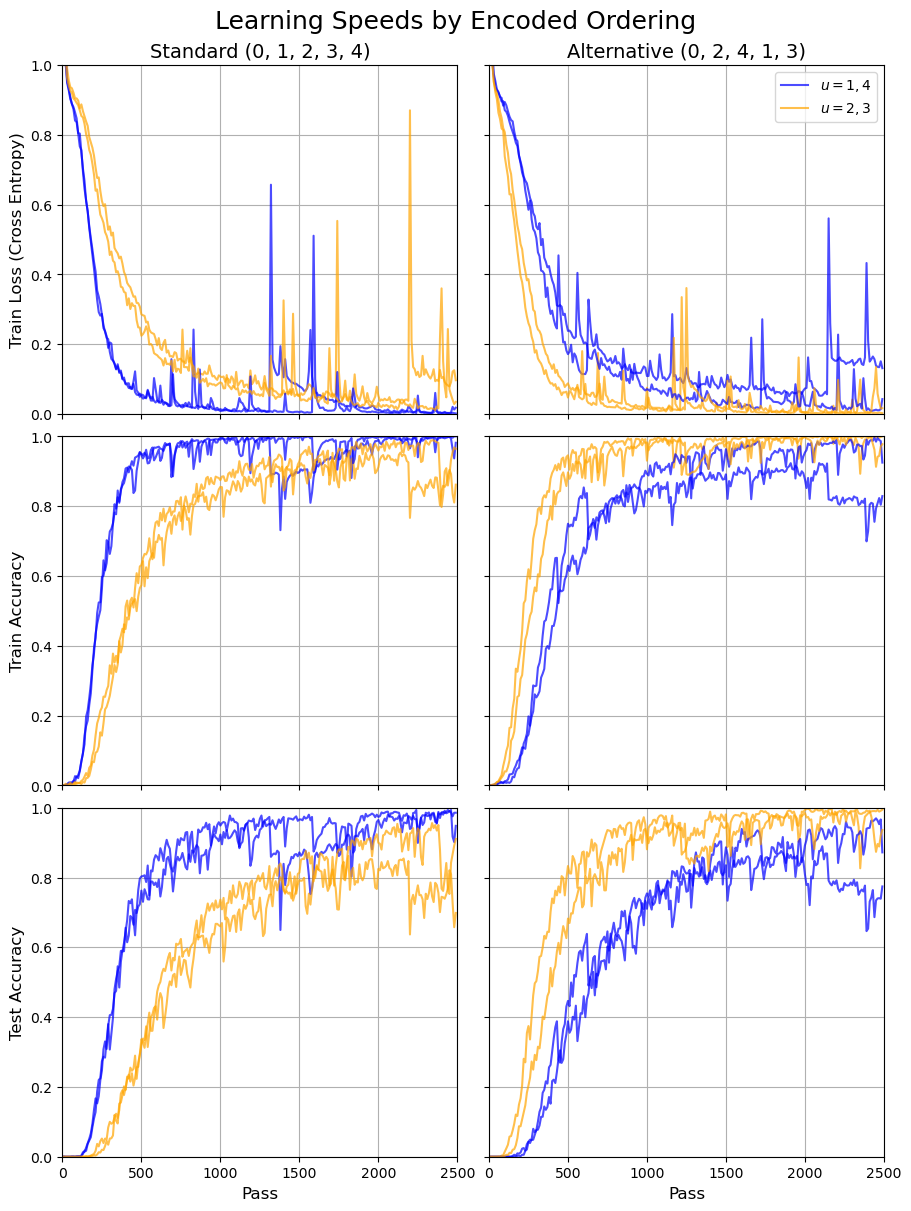

In [57]:
# create subplots, title figure
fig, axes = plt.subplots(3, 2, figsize=(9, 12), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Learning Speeds by Encoded Ordering', fontsize=18)

b = 5
for i in range(2):
    for j in range(3):

        # get b, learning Speeds
        u = i + 1
        with open(f'../pickles/learning_metrics/learning_metrics5_semantic{u}.pickle', 'rb') as f:
            learning_metrics = pickle.load(f)

        # get ax, set basic formatting
        ax = axes[j, i]
        ax.grid(True)
        ax.set_xlim(0, 250)
        ax.set_ylim(0)
        ax.set_xticks(np.linspace(0, 250, 6), np.linspace(0, 2500, 6).astype('int'))

        # loss plot
        if j == 0:
            if i == 0:
                ax.set_title('Standard (0, 1, 2, 3, 4)', fontsize=14)
            if i == 1:
                ax.set_title('Alternative (0, 2, 4, 1, 3)', fontsize=14)
            for dc in learning_metrics.keys():
                loss = learning_metrics[dc]['loss']
                if np.unique(all_tables[b][dc])[1] in [1, 4]:
                    std, = ax.plot(loss, color='blue', alpha=0.7, label='$u=1, 4$')
                elif np.unique(all_tables[b][dc])[1] in [2, 3]:
                    alt, = ax.plot(loss, color='orange', alpha=0.7, label='$u=2, 3$')
            if i == 0:
                ax.set_ylabel('Train Loss (Cross Entropy)', fontsize=12)
            elif i == 1:
                ax.legend(handles=[std, alt])
    
        # training accuracy plot
        if j == 1:
            for dc in learning_metrics.keys():
                train_acc = learning_metrics[dc]['training_acc']
                if np.unique(all_tables[b][dc])[1] in [1, 4]:
                    ax.plot(train_acc, color='blue', alpha=0.7, label='$u=1$')
                elif np.unique(all_tables[b][dc])[1] in [2, 3]:
                    ax.plot(train_acc, color='orange', alpha=0.7, label='$u=2, 3$')
            if i == 0:
                ax.set_ylabel('Train Accuracy', fontsize=12)
    
        # testing accuracy plot
        if j == 2:
            for dc in learning_metrics.keys():
                test_acc = learning_metrics[dc]['testing_acc']
                if np.unique(all_tables[b][dc])[1] in [1, 4]:
                    ax.plot(test_acc, color='blue', alpha=0.7, label='$u=1, 4$')
                elif np.unique(all_tables[b][dc])[1] in [2, 3]:
                    ax.plot(test_acc, color='orange', alpha=0.7, label='$u=2, 3$')
            ax.set_xlabel('Pass', fontsize=12)
            if i == 0:
                ax.set_ylabel('Test Accuracy', fontsize=12)
    plt.savefig('../figures/learning_speeds_ordering.png', dpi=300)

## Correlate Metrics

### Fit sigmoid function to accuracy curves

In [186]:
def acc(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))

In [187]:
base = 5
with open(f'../pickles/learning_metrics/learning_metrics{base}_10trials.pickle', 'rb') as f:
    learning_metrics = pickle.load(f)

In [188]:
best_dc = -1
min_err = math.inf
all_errs = []
R2s = []
for base in range(3, 6):
    with open(f'../pickles/learning_metrics/learning_metrics{base}_10trials.pickle', 'rb') as f:
        learning_metrics = pickle.load(f)
    for dc in learning_metrics.keys():
        x = np.arange(250)
        y = learning_metrics[dc]['testing_acc']
        try:
            (a, b, c), cov = curve_fit(acc, x, y)
        except:
            continue
        err = np.sum((y - acc(x, a, b, c))**2)
        var = np.sum((y - y.mean())**2)
        R2 = 1 - err/var
        R2s.append(R2)
        all_errs.append(err)
        if (err < min_err) and (np.max(y) > 0.8):
            min_err = err
            best_dc = dc
            print(R2)

0.9754678684574355
0.979603898886424
0.972961248253289
0.9796045610559604
0.9824824622617884


/var/folders/s1/tvdnvl8n0l52wc16d3x78qlw0000gn/T/ipykernel_2471/4099419075.py:2: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c)))


In [189]:
all_errs = np.array(all_errs)
all_errs.mean()

0.12966797325920412

In [190]:
all_errs.std()

0.11640148594418677

In [191]:
R2s = np.array(R2s)
R2s.mean()

0.9217603165697675

In [192]:
R2s.std()

0.03907494973098634

In [193]:
x = np.arange(250)
y = learning_metrics[best_dc]['testing_acc']
N = np.where(y >= 0.99 * np.max(y))[0][0]
x = x[:N]
y = y[:N]
(a, b, c), cov = curve_fit(acc, x, y)

Text(0.5, 1.0, 'Sigmoid Fit of An Accuracy Curve')

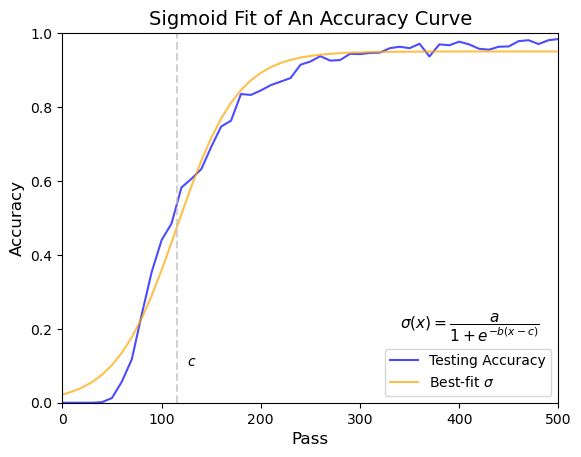

In [194]:
plt.plot(y, color='blue', alpha=0.7, label='Testing Accuracy')
plt.plot(acc(x, a, b, c), color='orange', alpha=0.7, label=r'Best-fit $\sigma$')
plt.axvline(c, color='silver', alpha=0.7, linestyle='--')
plt.text(c+1, 0.1, '$c$')
plt.text(34, 0.2, r'$\sigma(x) = \dfrac{a}{1+e^{-b(x-c)}}$', fontsize=11)
plt.legend()
# plt.grid(True)
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.xticks(np.linspace(0, 50, 6), np.linspace(0, 500, 6).astype('int'))
plt.xlabel('Pass', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Sigmoid Fit of An Accuracy Curve', fontsize=14)
# plt.savefig('../figures/sigmoid_fit.png', dpi=300)

### Get all metrics

In [27]:
with open('../pickles/complexity_measures/est_dim_box_vs_depth.pickle', 'rb') as f:
    est_dim_box_vs_depth = pickle.load(f)

In [196]:
with open('../pickles/complexity_measures/associativity_d6.pickle', 'rb') as f:
    all_associativity = pickle.load(f)

In [197]:
with open('../pickles/complexity_measures/frac_zeros_vs_depth.pickle', 'rb') as f:
    all_frac_zeros = pickle.load(f)

In [198]:
with open('../pickles/complexity_measures/num_digits_vs_depth.pickle', 'rb') as f:
    all_num_digits = pickle.load(f)

In [199]:
all_est_dims = {}
all_critical_pts = {}

for base in range(3, 6):
    x = np.arange(250)
    with open(f'../pickles/learning_metrics/learning_metrics{base}_10trials.pickle', 'rb') as f:
        learning_metrics = pickle.load(f)
    est_dims = [est_dim_box_vs_depth[base][dc][3] for dc in all_tables[base].keys()]
    critical_pts = []
    for dc in all_tables[base].keys():
        # create x and y
        x = np.arange(250)
        y = learning_metrics[dc]['testing_acc']
        # crop x and y
        N = np.where(y >= 0.99*np.max(y))[0][0]
        x = x[:N]
        y = y[:N]
        try:
            (a, b, c), cov = curve_fit(acc, x, y)
        except:
            c = -1
        # # append only if non-unit carry
        # if len(np.unique(fn.construct_table(dc))) == 2:
        #     c = -1
        critical_pts.append(c)
    all_est_dims[base] = est_dims
    all_critical_pts[base] = critical_pts

/var/folders/s1/tvdnvl8n0l52wc16d3x78qlw0000gn/T/ipykernel_2471/4099419075.py:2: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c)))


In [200]:
valid = lambda x: x > 0
for b in range(3, 6):
    critical_pts = all_critical_pts[b]
    est_dims = all_est_dims[b]
    associativity = list(all_associativity[b].values())
    # frac_zeros = [all_frac_zeros[b][dc][0] for dc in all_tables[b].keys()]
    frac_zeros = [sum(all_frac_zeros[b][dc]) / len(all_frac_zeros[b][dc]) for dc in all_tables[b].keys()]
    num_digits = [all_num_digits[b][dc][0] for dc in all_tables[b].keys()]
    valid_tuples = [(crit_pt, est_dim, frac_assoc, frac_zero, num_digit) for crit_pt, est_dim, frac_assoc, frac_zero, num_digit
                    in zip(critical_pts, est_dims, associativity, frac_zeros, num_digits) if valid(crit_pt)]
    critical_pts = [crit_pt for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    est_dims = [est_dim for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    associativity = [frac_assoc for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    frac_zeros = [frac_zero for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    num_digits = [num_digit for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    all_critical_pts[b] = critical_pts
    all_est_dims[b] = est_dims
    all_associativity[b] = associativity
    all_frac_zeros[b] = frac_zeros
    all_num_digits[b] = num_digits

In [201]:
# divide critical points by min. across base
for b in range(3, 6):
    all_critical_pts[b] = list(all_critical_pts[b] / np.min(all_critical_pts[b]))

In [202]:
# get flattened arrays on which to compute statistics
associativity_flat = []
est_dims_flat = []
critical_pts_flat = []
frac_zeros_flat = []
num_digits_flat = []
for b in all_est_dims.keys():
    est_dims_flat += all_est_dims[b]
    critical_pts_flat += all_critical_pts[b]
    associativity_flat += all_associativity[b]
    frac_zeros_flat += all_frac_zeros[b]
    num_digits_flat += all_num_digits[b]

In [203]:
# convert to arrays
for b in range(3, 6):
    all_critical_pts[b] = np.array(all_critical_pts[b])
    all_est_dims[b] = np.array(all_est_dims[b])
    all_associativity[b] = np.array(all_associativity[b])
    all_frac_zeros[b] = np.array(all_frac_zeros[b])
    all_num_digits[b] = np.array(all_num_digits[b])

In [204]:
# get carry freq by subtracting number of zeros from 1
all_carry_freq = {}
for b in range(3, 6):
    all_carry_freq[b] = 1 - all_frac_zeros[b]
carry_freq_flat = 1 - np.array(frac_zeros_flat)

In [205]:
# get indices of special non-unit carries
unit_inds = {}
special_inds = {}
non_unit_inds = {}
for b in range(3, 6):
    unit_inds[b], = np.where(np.array(all_est_dims[b]) < 1.25)
    special_inds[b], = np.where((np.array(all_est_dims[b]) >= 1.25) & (np.array(all_est_dims[b]) < 1.5))
    non_unit_inds[b], = np.where(np.array(all_est_dims[b]) >= 1.5)

### Correlate box-counting dim with learning Speed

**HOW TO CORRELATE WITH MULTIPLE SAMPLES**

In [206]:
r = scipy.stats.spearmanr(est_dims_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(est_dims_flat, critical_pts_flat).pvalue

Text(0.5, 1.0, 'Correlation Between Fractal Dimension and Learning Speed')

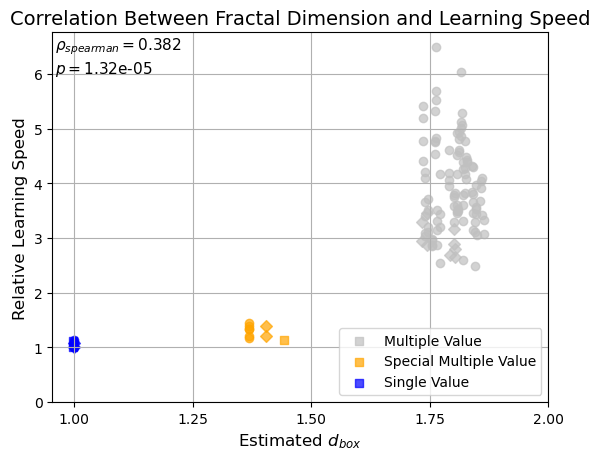

In [207]:
fig = plt.figure()
# plot non-units (w/o special)
plt.scatter(all_est_dims[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Multiple Value')
plt.scatter(all_est_dims[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
plt.scatter(all_est_dims[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
plt.scatter(all_est_dims[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Special Multiple Value')
plt.scatter(all_est_dims[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
plt.scatter(all_est_dims[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
plt.scatter(all_est_dims[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
plt.scatter(all_est_dims[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
plt.scatter(all_est_dims[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
plt.legend(loc = 'lower right')
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
plt.text(0.13, 0.795, text, fontsize=11, transform=fig.transFigure)
plt.xticks(np.linspace(1, 2, 5))
plt.yticks(np.linspace(0, 6, 7))
plt.grid(True) 
plt.xlabel('Estimated '+r'$d_{box}$', fontsize=12)
plt.ylabel('Relative Learning Speed', fontsize=12)
plt.title('Correlation Between Fractal Dimension and Learning Speed', fontsize=14)
# plt.savefig('../figures/correlation_dim_box.png', dpi=300)

### Correlate associativity fraction with learning Speed

In [208]:
r = scipy.stats.spearmanr(associativity_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(associativity_flat, critical_pts_flat).pvalue

Text(0.5, 1.0, 'Correlation Between Associativity and Learning Speed')

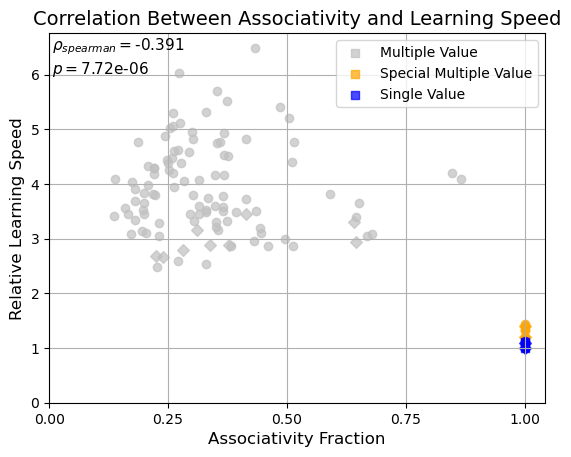

In [209]:
fig = plt.figure()
# plot non-units (w/o special)
plt.scatter(all_associativity[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Multiple Value')
plt.scatter(all_associativity[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
plt.scatter(all_associativity[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
plt.scatter(all_associativity[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Special Multiple Value')
plt.scatter(all_associativity[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
plt.scatter(all_associativity[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
plt.scatter(all_associativity[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
plt.scatter(all_associativity[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
plt.scatter(all_associativity[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
plt.legend(loc = 'upper right')
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
plt.text(0.13, 0.795, text, fontsize=11, transform=fig.transFigure)
plt.xticks(np.linspace(0, 1, 5))
plt.yticks(np.linspace(0, 6, 7))
plt.grid(True)
plt.xlabel('Associativity Fraction', fontsize=12)
plt.ylabel('Relative Learning Speed', fontsize=12)
plt.title('Correlation Between Associativity and Learning Speed', fontsize=14)
# plt.savefig('../figures/correlation_associativity.png', dpi=300)

### Correlate with Frequency of Carrying

In [210]:
r = scipy.stats.spearmanr(carry_freq_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(carry_freq_flat, critical_pts_flat).pvalue

Text(0.5, 1.0, 'Correlation Between Frequency of Carrying and Learning Speed')

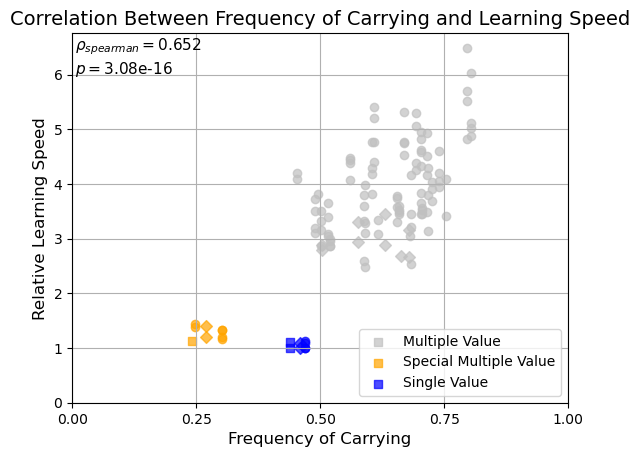

In [211]:
fig = plt.figure()
# plot non-units (w/o special)
plt.scatter(all_carry_freq[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Multiple Value')
plt.scatter(all_carry_freq[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
plt.scatter(all_carry_freq[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
plt.scatter(all_carry_freq[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Special Multiple Value')
plt.scatter(all_carry_freq[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
plt.scatter(all_carry_freq[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
plt.scatter(all_carry_freq[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
plt.scatter(all_carry_freq[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
plt.scatter(all_carry_freq[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
plt.legend(loc = 'lower right')
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
plt.text(0.13, 0.795, text, fontsize=11, transform=fig.transFigure)
plt.xticks(np.linspace(0, 1, 5))
plt.yticks(np.linspace(0, 6, 7))
plt.grid(True)
plt.xlabel('Frequency of Carrying', fontsize=12)
plt.ylabel('Relative Learning Speed', fontsize=12)
plt.title('Correlation Between Frequency of Carrying and Learning Speed', fontsize=14)
# plt.savefig('../figures/correlation_carry_freq.png', dpi=300)

### Correlate with Number of Unique Carries

In [212]:
r = scipy.stats.spearmanr(num_digits_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(num_digits_flat, critical_pts_flat).pvalue

Text(0.5, 1.0, 'Correlation Between Number of Unique Carries and Learning Speed')

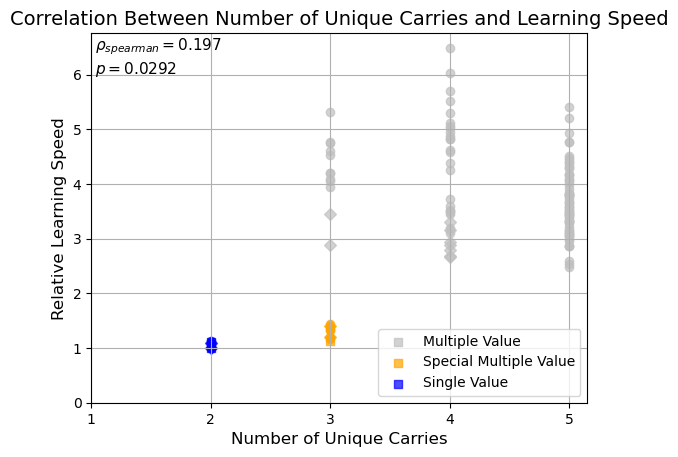

In [213]:
fig = plt.figure()
# plot non-units (w/o special)
plt.scatter(all_num_digits[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Multiple Value')
plt.scatter(all_num_digits[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
plt.scatter(all_num_digits[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
plt.scatter(all_num_digits[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Special Multiple Value')
plt.scatter(all_num_digits[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
plt.scatter(all_num_digits[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
plt.scatter(all_num_digits[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
plt.scatter(all_num_digits[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
plt.scatter(all_num_digits[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
plt.legend(loc = 'lower right')
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
plt.text(0.13, 0.795, text, fontsize=11, transform=fig.transFigure)
plt.xticks(np.linspace(1, 5, 5))
plt.yticks(np.linspace(0, 6, 7))
plt.grid(True)
plt.xlabel('Number of Unique Carries', fontsize=12)
plt.ylabel('Relative Learning Speed', fontsize=12)
plt.title('Correlation Between Number of Unique Carries and Learning Speed', fontsize=14)
# plt.savefig('../figures/correlation_num_carries.png', dpi=300)

### Experimentation

In [77]:
carry_freq_flat.shape

(123,)

In [78]:
print(np.corrcoef(est_dims_flat, critical_pts_flat)[0][1])
print(np.corrcoef(carry_freq_flat, critical_pts_flat)[0][1])
print(np.corrcoef(associativity_flat, critical_pts_flat)[0][1])

print(np.corrcoef(est_dims_flat, carry_freq_flat)[0][1])
print(np.corrcoef(est_dims_flat, associativity_flat)[0][1])
print(np.corrcoef(carry_freq_flat, associativity_flat)[0][1])

0.7311523811684866
0.7539321988076649
-0.6846878168202726
0.6341756430643649
-0.8726937923272023
-0.8038110238150484


In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [80]:
complexity = np.column_stack((est_dims_flat, carry_freq_flat, associativity_flat))

# standardize the data
scaler = StandardScaler()
complexity_standardized = scaler.fit_transform(complexity)

# perform PCA
pca = PCA(n_components=1)  # extract only the first principal component
pc1_flat = pca.fit_transform(complexity_standardized).ravel()

In [81]:
all_pc1 = {}
t = 0
for b in range(3, 6):
    l = len(all_carry_freq[b])
    all_pc1[b] = pc1_flat[t:t+l]
    t += l

In [82]:
r = scipy.stats.spearmanr(pc1_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(pc1_flat, critical_pts_flat).pvalue

Text(0.5, 1.0, 'Correlation Between 1st Principal Component and Learning Speed')

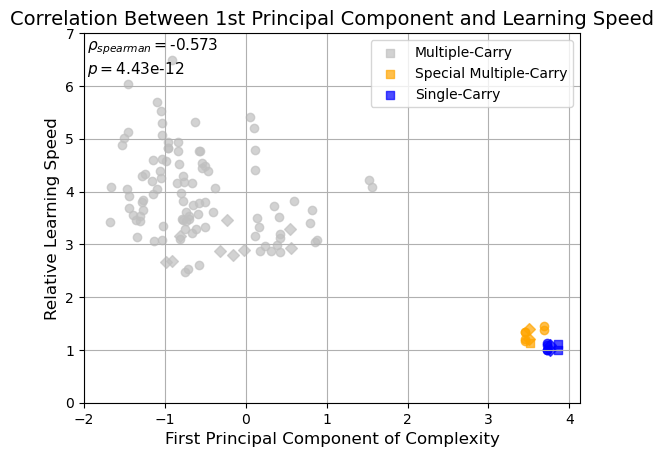

In [83]:
fig = plt.figure()
# plot non-units (w/o special)
plt.scatter(all_pc1[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Multiple Value')
plt.scatter(all_pc1[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
plt.scatter(all_pc1[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
plt.scatter(all_pc1[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Special Multiple Value')
plt.scatter(all_pc1[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
plt.scatter(all_pc1[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
plt.scatter(all_pc1[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
plt.scatter(all_pc1[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
plt.scatter(all_pc1[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
plt.legend(loc = 'upper right')
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
plt.text(0.13, 0.795, text, fontsize=11, transform=fig.transFigure)
plt.xticks(np.linspace(-2, 4, 7))
plt.yticks(np.linspace(0, 7, 8))
plt.grid(True)
plt.xlabel('First Principal Component of Complexity', fontsize=12)
plt.ylabel('Relative Learning Speed', fontsize=12)
plt.title('Correlation Between 1st Principal Component and Learning Speed', fontsize=14)
# plt.savefig('../figures/correlation_1st_PC.png', dpi=300)

### Combine the correlation figures

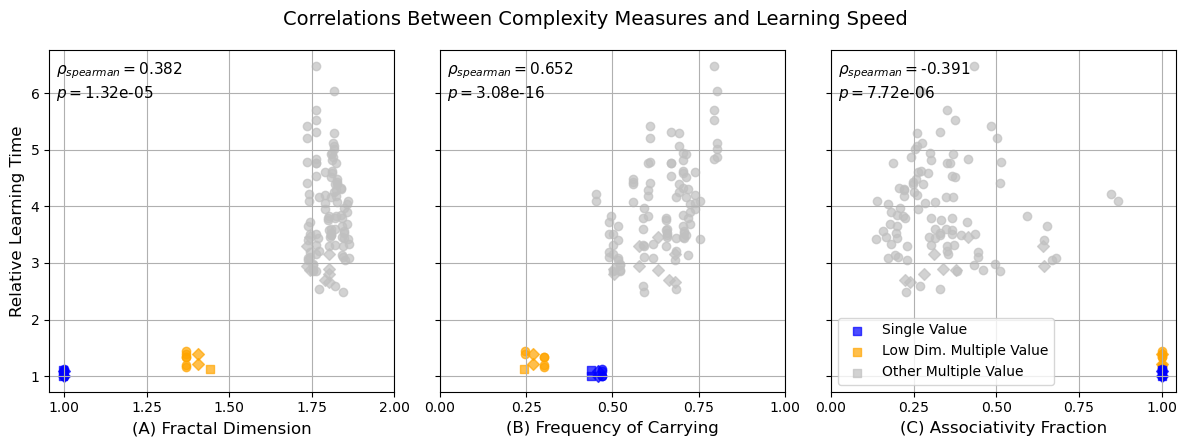

In [214]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), sharey=True)

# correlate estimated box-counting dimension with learning speed
r = scipy.stats.spearmanr(est_dims_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(est_dims_flat, critical_pts_flat).pvalue
# plot non-units (w/o special)
axes[0].scatter(all_est_dims[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Other Multiple Value')
axes[0].scatter(all_est_dims[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
axes[0].scatter(all_est_dims[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
axes[0].scatter(all_est_dims[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Low Dim. Multiple Value')
axes[0].scatter(all_est_dims[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
axes[0].scatter(all_est_dims[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
axes[0].scatter(all_est_dims[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
axes[0].scatter(all_est_dims[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
axes[0].scatter(all_est_dims[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
axes[0].text(0.02, 0.86, text, fontsize=11, transform=axes[0].transAxes)
axes[0].set_xticks(np.linspace(1, 2, 5))
axes[0].grid(True) 
axes[0].set_xlabel('(A) Fractal Dimension', fontsize=12)
axes[0].set_ylabel('Relative Learning Time', fontsize=12)

# correlate with Frequency of Carrying
r = scipy.stats.spearmanr(carry_freq_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(carry_freq_flat, critical_pts_flat).pvalue
# plot non-units (w/o special)
axes[1].scatter(all_carry_freq[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Other Multiple Value')
axes[1].scatter(all_carry_freq[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
axes[1].scatter(all_carry_freq[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
axes[1].scatter(all_carry_freq[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Low Dim. Multiple Value')
axes[1].scatter(all_carry_freq[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
axes[1].scatter(all_carry_freq[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
axes[1].scatter(all_carry_freq[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
axes[1].scatter(all_carry_freq[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
axes[1].scatter(all_carry_freq[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
axes[1].text(0.02, 0.86, text, fontsize=11, transform=axes[1].transAxes)
axes[1].set_xticks(np.linspace(0, 1, 5))
axes[1].set_yticks(np.linspace(0, 6, 7))
axes[1].grid(True)
axes[1].set_xlabel('(B) Frequency of Carrying', fontsize=12)

# correlate associativity fraction with learning speed
r = scipy.stats.spearmanr(associativity_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(associativity_flat, critical_pts_flat).pvalue
# plot non-units (w/o special)
non_units = axes[2].scatter(all_associativity[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Other Multiple Value')
axes[2].scatter(all_associativity[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
axes[2].scatter(all_associativity[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
special_non_units = axes[2].scatter(all_associativity[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Low Dim. Multiple Value')
axes[2].scatter(all_associativity[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
axes[2].scatter(all_associativity[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
units = axes[2].scatter(all_associativity[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
axes[2].scatter(all_associativity[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
axes[2].scatter(all_associativity[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
axes[2].text(0.02, 0.86, text, fontsize=11, transform=axes[2].transAxes)
axes[2].set_xticks(np.linspace(0, 1, 5))
axes[2].grid(True)
axes[2].set_xlabel('(C) Associativity Fraction', fontsize=12)
axes[2].legend(handles=[units, special_non_units, non_units], loc='lower left')

fig.suptitle('Correlations Between Complexity Measures and Learning Speed', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/correlations.png', dpi=300)

## SCRATCH

### Investigate the Special Multiple Value Carries

In [38]:
all_carry_freq = {}
for b in range(3, 6):
    carry_freq = {}
    for dc, table in all_tables[b].items():
        carry_freq[dc] = np.count_nonzero(table) / float(table.size)
    all_carry_freq[b] = carry_freq

In [39]:
all_special_tables = {}
for b in range(3, 6):
    special_tables = {}
    for dc, carry_freq in all_carry_freq[b].items():
        dim_box = est_dim_box_vs_depth[b][dc][3]
        if (dim_box >= 1.25) and (dim_box < 1.5):
            table = fn.construct_table(dc)
            special_tables[dc] = table
    all_special_tables[b] = special_tables

In [40]:
u = np.unique(table).max()

In [41]:
from fn import BaseElt

In [42]:
e = BaseElt((0, 0), table)

In [43]:
g = BaseElt((0, 1), table)

In [44]:
(g + g).vals

(1, 2)

In [48]:
b = 3
table = all_special_tables[b][((0, 0, 0), (0, 1, 2), (0, 2, 1))]

In [51]:
for i in range(1, b):
    count = []
    x = BaseElt((0, 0), table)
    i = BaseElt((0, i), table)
    for _ in range(b**2 + 1):
        count.append(x.vals)
        x += i
    print(count)
    print()

[(0, 0, 0), (0, 0, 1), (0, 1, 2), (0, 1, 0), (0, 1, 1), (1, 2, 2), (1, 2, 0), (1, 2, 1), (1, 0, 2), (1, 0, 0), (1, 0, 1), (1, 1, 2), (1, 1, 0), (1, 1, 1), (2, 2, 2), (2, 2, 0), (2, 2, 1), (2, 0, 2), (2, 0, 0), (2, 0, 1), (2, 1, 2), (2, 1, 0), (2, 1, 1), (0, 2, 2), (0, 2, 0), (0, 2, 1), (0, 0, 2), (0, 0, 0)]

[(0, 0, 0), (0, 0, 2), (0, 2, 1), (0, 2, 0), (0, 2, 2), (2, 1, 1), (2, 1, 0), (2, 1, 2), (2, 0, 1), (2, 0, 0), (2, 0, 2), (2, 2, 1), (2, 2, 0), (2, 2, 2), (1, 1, 1), (1, 1, 0), (1, 1, 2), (1, 0, 1), (1, 0, 0), (1, 0, 2), (1, 2, 1), (1, 2, 0), (1, 2, 2), (0, 1, 1), (0, 1, 0), (0, 1, 2), (0, 0, 1), (0, 0, 0)]



In [55]:
for b in all_special_tables.keys():
    for dc, table in all_special_tables[b].items():
        print(table)
        count = []
        x = BaseElt((0, 0), table)
        i = np.unique(table)[1]
        i = BaseElt((0, i), table)
        for _ in range(b**2 + 1):
            count.append(x.vals)
            x += i
        print(count)
        print()

[[0 0 0]
 [0 1 0]
 [0 0 2]]
[(0, 0), (0, 1), (1, 2), (1, 0), (1, 1), (2, 2), (2, 0), (2, 1), (0, 2), (0, 0)]

[[0 0 0 0]
 [0 0 1 0]
 [0 1 1 0]
 [0 0 0 3]]
[(0, 0), (0, 1), (0, 2), (1, 3), (1, 0), (1, 1), (1, 2), (2, 3), (2, 0), (2, 1), (2, 2), (3, 3), (3, 0), (3, 1), (3, 2), (0, 3), (0, 0)]

[[0 0 0 0]
 [0 1 0 0]
 [0 0 3 3]
 [0 0 3 0]]
[(0, 0), (0, 1), (1, 2), (1, 3), (1, 0), (1, 1), (2, 2), (2, 3), (2, 0), (2, 1), (3, 2), (3, 3), (3, 0), (3, 1), (0, 2), (0, 3), (0, 0)]

[[0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 1 0]
 [0 1 1 1 0]
 [0 0 0 0 4]]
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 4), (1, 0), (1, 1), (1, 2), (1, 3), (2, 4), (2, 0), (2, 1), (2, 2), (2, 3), (3, 4), (3, 0), (3, 1), (3, 2), (3, 3), (4, 4), (4, 0), (4, 1), (4, 2), (4, 3), (0, 4), (0, 0)]

[[0 0 0 0 0]
 [0 0 1 0 0]
 [0 1 1 0 0]
 [0 0 0 4 4]
 [0 0 0 4 0]]
[(0, 0), (0, 1), (0, 2), (1, 3), (1, 4), (1, 0), (1, 1), (1, 2), (2, 3), (2, 4), (2, 0), (2, 1), (2, 2), (3, 3), (3, 4), (3, 0), (3, 1), (3, 2), (4, 3), (4, 4), (4, 0), (4, 1), (4, 2

### Investigate Associativity Fraction vs Depth

In [57]:
with open('../pickles/complexity_measures/associativity_vs_depth_d6.pickle', 'rb') as f:
    associativity_vs_depth = pickle.load(f)

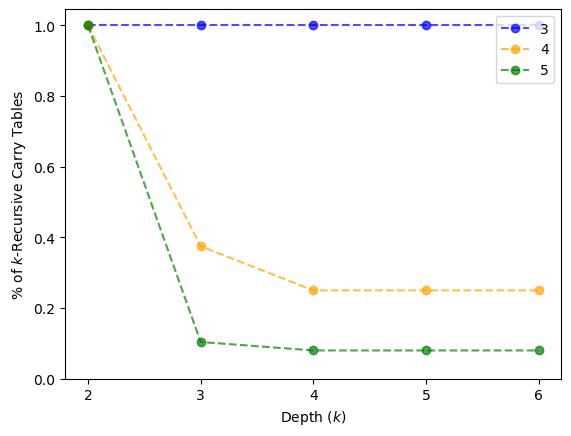

In [58]:
fig = plt.figure()

# plot percent of carry tables that are associative vs depth
depths = [2, 3, 4, 5, 6]
# base 3
stacked_assoc = np.stack(list(associativity_vs_depth[3].values()))
pct_assoc = np.mean(stacked_assoc == 1, axis=0)
plt.plot(depths, pct_assoc, alpha=0.7, marker='o', linestyle='--', color='blue', label=3)
# base 4
stacked_assoc = np.stack(list(associativity_vs_depth[4].values()))
pct_assoc = np.mean(stacked_assoc == 1, axis=0)
plt.plot(depths, pct_assoc, alpha=0.7, marker='o', linestyle='--', color='orange', label=4)
# base 5
stacked_assoc = np.stack(list(associativity_vs_depth[5].values()))
pct_assoc = np.mean(stacked_assoc == 1, axis=0)
plt.plot(depths, pct_assoc, alpha=0.7, marker='o', linestyle='--', color='green', label=5)

# formatting
plt.xticks(depths)
plt.yticks(np.linspace(0, 1, 6))
plt.xlabel(r'Depth ($k$)')
plt.ylabel(r'% of $k$-Recursive Carry Tables')
plt.legend(loc='upper right')
plt.savefig('../figures/pct_k-recursive.png', dpi=300)

### Investigate whether any carries carry non-units

In [68]:
from math import gcd

In [79]:
for b in all_tables.keys():
    for dc, table in all_tables[b].items():
        dim_box = est_dim_box_vs_depth[b][dc][3]
        if len(np.unique(table)) == 3 and dim_box > 1.5:
            print(dc)
            print(table)
            print()

((0, 0, 0, 0), (0, 3, 0, 1), (0, 0, 2, 2), (0, 1, 2, 1))
[[0 0 0 0]
 [0 3 0 2]
 [0 0 3 3]
 [0 2 3 2]]

((0, 0, 0, 0), (0, 2, 1, 1), (0, 1, 0, 3), (0, 1, 3, 0))
[[0 0 0 0]
 [0 2 1 2]
 [0 1 1 0]
 [0 2 0 1]]

((0, 0, 0, 0, 0), (0, 0, 0, 3, 2), (0, 0, 3, 0, 2), (0, 3, 0, 0, 2), (0, 2, 2, 2, 4))
[[0 0 0 0 0]
 [0 0 0 3 3]
 [0 0 3 1 3]
 [0 3 1 1 3]
 [0 3 3 3 0]]

((0, 0, 0, 0, 0), (0, 0, 2, 2, 1), (0, 2, 4, 3, 1), (0, 2, 3, 1, 4), (0, 1, 1, 4, 4))
[[0 0 0 0 0]
 [0 0 2 2 2]
 [0 2 4 4 2]
 [0 2 4 2 0]
 [0 2 2 0 0]]

((0, 0, 0, 0, 0), (0, 0, 2, 0, 3), (0, 2, 2, 3, 3), (0, 0, 3, 1, 1), (0, 3, 3, 1, 3))
[[0 0 0 0 0]
 [0 0 2 0 4]
 [0 2 2 4 4]
 [0 0 4 2 2]
 [0 4 4 2 4]]

((0, 0, 0, 0, 0), (0, 4, 0, 4, 2), (0, 0, 0, 2, 3), (0, 4, 2, 2, 2), (0, 2, 3, 2, 3))
[[0 0 0 0 0]
 [0 4 0 4 3]
 [0 0 0 3 4]
 [0 4 3 3 3]
 [0 3 4 3 4]]

((0, 0, 0, 0, 0), (0, 4, 4, 0, 2), (0, 4, 0, 3, 3), (0, 0, 3, 4, 3), (0, 2, 3, 3, 2))
[[0 0 0 0 0]
 [0 4 4 0 3]
 [0 4 0 4 4]
 [0 0 4 0 4]
 [0 3 4 4 3]]

((0, 0, 0, 0, 0), (0, 2, 2, 2

IndexError: list index out of range